In [1]:
from os.path import join
from random import choice, randint

from pandas import DataFrame

from ai_tools import DataGenerator, ModelManager
from ai_tools.helpers import create_data_frame_from_path, split_stratified_into_train_val_test
from ai_tools.displays import  plot_history

from tensorflow.keras.callbacks import History

# Paths.
dataset_path: str = '/mnt/datasets/serialized_dataset'
logs_path: str = '/mnt/logs'
aim_logs_path: str = '/mnt/aim'
model_checkpoint_path: str = '/mnt/model-checkpoints'
model_histories: str = '/mnt/model_histories'
model_config_csv_log_path: str = '/mnt/model_settings.csv'

# Settings.
batch_size: int = 32

### Create dataset.

In [2]:
# Create dataset dataframe and split it into train, validation, and test.
df: DataFrame = create_data_frame_from_path(
    dataset_path,
    number_of_samples_for_each_class=2_000
)

df_train, df_val, df_test = split_stratified_into_train_val_test(df)  # type: DataFrame, DataFrame, DataFrame

# Store the data generator data frame for recreating the data generator if needed.
df_train.to_csv(join(logs_path, 'train_data.csv'))
df_val.to_csv(join(logs_path, 'val_data.csv'))
df_test.to_csv(join(logs_path, 'test_data.csv'))

In [3]:
# Create Generators.
train_data_generator: DataGenerator = DataGenerator(df_train, batch_size=batch_size)
val_data_generator: DataGenerator = DataGenerator(df_val, batch_size=batch_size)
test_data_generator: DataGenerator = DataGenerator(df_test, batch_size=batch_size)

In [4]:
train_data_generator.get_data_frame.head()

,path,instrument,pitch,instrument_label,pitch_label
0,/mnt/datasets/serialized_dataset/reed/reed_F#_...,reed,F#,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,/mnt/datasets/serialized_dataset/bass/bass_E_0...,bass,E,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,/mnt/datasets/serialized_dataset/bass/bass_C_0...,bass,C,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,/mnt/datasets/serialized_dataset/synth/synth_D...,synth,D#,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,/mnt/datasets/serialized_dataset/reed/reed_B_0...,reed,B,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
model_manager = ModelManager(
    path_to_csv_logs=model_config_csv_log_path,
    model_checkpoint_dir=model_checkpoint_path,
    aim_logs_dir=aim_logs_path,
    history_log_dir=model_histories
)

model_manager.build_model(
    num_conv_block=4,
    num_filters=64,
    dense_layer_size=64,
    num_dense_layers=1,
    use_separable_conv_layer=False,
    use_regularization=True,
    use_dropout_dense_layers=True,
    use_dropout_conv_blocks=True
)

accuracy: float = model_manager.train_and_optimize_model(
    train_data_generator,
    val_data_generator,
    test_data_generator,
    epochs=100
)

2022-03-12 15:12:18.979402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 15:12:18.985415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 15:12:18.985925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 15:12:18.986806: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Assets written to: /mnt/model-checkpoints/model_118/epoch-01.pb/assets
INFO:tensorflow:Assets written to: /mnt/model-checkpoints/model_118/epoch-02.pb/assets
INFO:tensorflow:Assets written to: /mnt/model-checkpoints/model_118/epoch-03.pb/assets
INFO:tensorflow:Assets written to: /mnt/model-checkpoints/model_118/epoch-07.pb/assets
INFO:tensorflow:Assets written to: ram://65f486ec-4ce5-4b85-a6f6-0e88298bfeff/assets


Got history for model_118


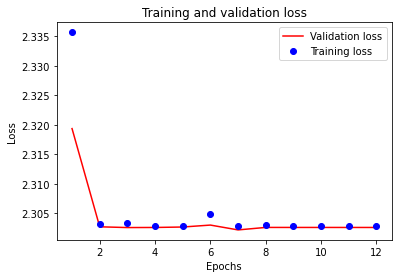

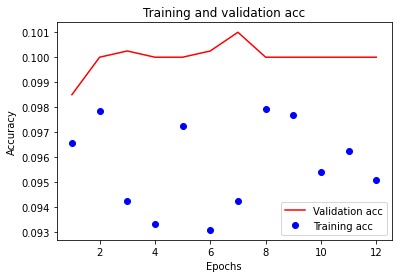

In [10]:
history: History = model_manager.get_model_history(118)

plot_history(history)